<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/Correccion_arti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpy

Tiempo de espera promedio: 10.51 minutos ± 1.82
Longitud promedio de la cola: 7.66 personas ± 1.30
Número promedio de combis necesarias: 9.87 ± 0.54

--- Comparación con datos reales ---
Combis simuladas vs reales: 9.87 vs 13
Tiempo de espera promedio simulado vs real: 10.51 vs 5.00


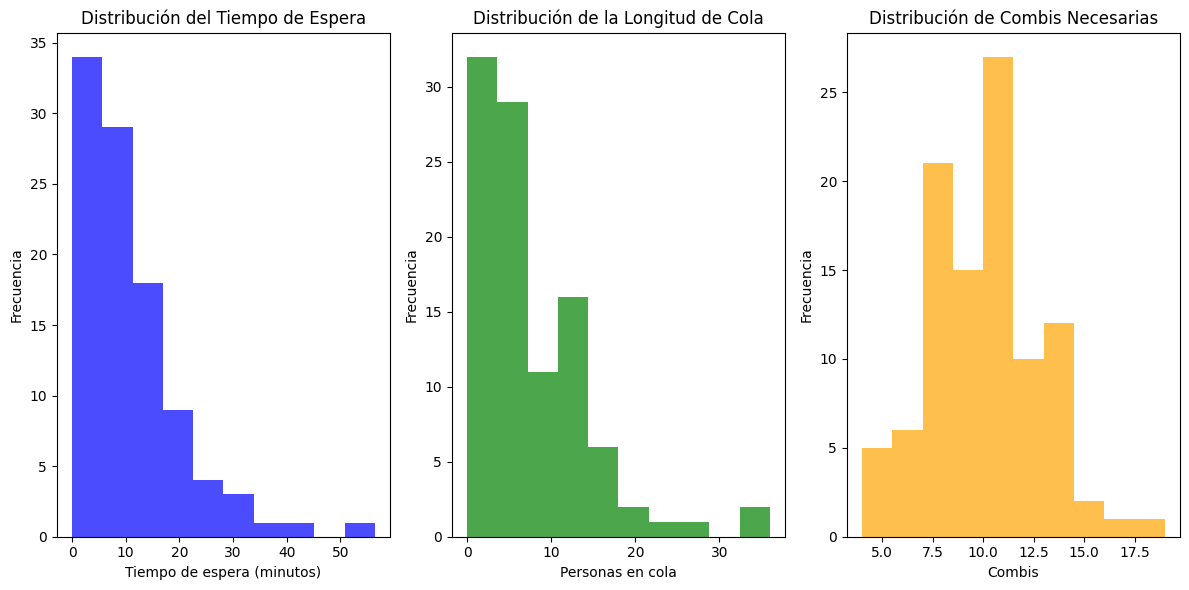

In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del modelo
tasa_llegada_pasajeros = 1 / 3  # 1 pasajero cada 3 minutos
tasa_llegada_combis = 1 / 15   # 1 combi cada 15 minutos
capacidad_combi = 15           # Máximo número de pasajeros por combi
tiempo_abordaje_por_pasajero = 0.5  # Minutos por pasajero

def llegada_pasajeros(env, cola):
    while True:
        yield env.timeout(random.expovariate(tasa_llegada_pasajeros))
        llegada = env.now
        cola.append(llegada)

def llegada_combis(env, cola, combis_necesarias, tiempos_abordo):
    while True:
        yield env.timeout(random.expovariate(tasa_llegada_combis))
        combis_necesarias.append(1)

        if len(cola) > 0:
            abordados = min(len(cola), capacidad_combi)
            tiempo_abordo = abordados * tiempo_abordaje_por_pasajero
            tiempos_abordo.append(tiempo_abordo)
            yield env.timeout(tiempo_abordo)
            cola[:abordados] = []  # Se vacía la cola de los pasajeros abordados

def simular(replicas, tiempo_simulacion):
    resultados_tiempo_espera = []
    resultados_longitud_cola = []
    resultados_combis_necesarias = []

    for _ in range(replicas):
        env = simpy.Environment()
        cola = []
        combis_necesarias = []
        tiempos_abordo = []

        env.process(llegada_pasajeros(env, cola))
        env.process(llegada_combis(env, cola, combis_necesarias, tiempos_abordo))

        env.run(until=tiempo_simulacion)

        # Métricas
        tiempos_espera = [env.now - llegada for llegada in cola]
        resultados_tiempo_espera.append(np.mean(tiempos_espera) if tiempos_espera else 0)
        resultados_longitud_cola.append(len(cola))
        resultados_combis_necesarias.append(sum(combis_necesarias))

    return resultados_tiempo_espera, resultados_longitud_cola, resultados_combis_necesarias

# Parámetros de simulación
replicas = 100

tiempo_simulacion = 180  # 3 horas (180 minutos)

# Ejecución de la simulación
resultados_tiempo_espera, resultados_longitud_cola, resultados_combis_necesarias = simular(replicas, tiempo_simulacion)

# Cálculo de promedios e intervalos de confianza
mean_tiempo_espera = np.mean(resultados_tiempo_espera)
mean_longitud_cola = np.mean(resultados_longitud_cola)
mean_combis_necesarias = np.mean(resultados_combis_necesarias)

ic_tiempo_espera = 1.96 * np.std(resultados_tiempo_espera) / np.sqrt(replicas)
ic_longitud_cola = 1.96 * np.std(resultados_longitud_cola) / np.sqrt(replicas)
ic_combis_necesarias = 1.96 * np.std(resultados_combis_necesarias) / np.sqrt(replicas)

# Resultados
print(f"Tiempo de espera promedio: {mean_tiempo_espera:.2f} minutos ± {ic_tiempo_espera:.2f}")
print(f"Longitud promedio de la cola: {mean_longitud_cola:.2f} personas ± {ic_longitud_cola:.2f}")
print(f"Número promedio de combis necesarias: {mean_combis_necesarias:.2f} ± {ic_combis_necesarias:.2f}")

# Comparación con datos reales
datos_reales_combis = 13  # Número de combis operativas
datos_reales_tiempo_espera = 5.0  # Tiempo promedio de espera real (supuesto)
print("\n--- Comparación con datos reales ---")
print(f"Combis simuladas vs reales: {mean_combis_necesarias:.2f} vs {datos_reales_combis}")
print(f"Tiempo de espera promedio simulado vs real: {mean_tiempo_espera:.2f} vs {datos_reales_tiempo_espera:.2f}")

# Gráficos
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(resultados_tiempo_espera, bins=10, color='blue', alpha=0.7)
plt.title("Distribución del Tiempo de Espera")
plt.xlabel("Tiempo de espera (minutos)")
plt.ylabel("Frecuencia")

plt.subplot(1, 3, 2)
plt.hist(resultados_longitud_cola, bins=10, color='green', alpha=0.7)
plt.title("Distribución de la Longitud de Cola")
plt.xlabel("Personas en cola")
plt.ylabel("Frecuencia")

plt.subplot(1, 3, 3)
plt.hist(resultados_combis_necesarias, bins=10, color='orange', alpha=0.7)
plt.title("Distribución de Combis Necesarias")
plt.xlabel("Combis")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()
